In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
N_POINTS = 64
DOMAIN_SIZE = 1.0 #m
N_ITERATIONS = 5000
# dt = 0.001 #time step, sec
nu = 0.1 #nu=mu/rho - kinematic viscosity, m2/sec
rho = 1.0 #density, g/m3
mu = nu*rho
HORIZONTAL_VELOCITY_TOP = 1.0 #m/s

N_PRESSURE_POISSON_ITERATIONS = 50
C = 0.5 #CFL
umax = 10
pout = 100
def velocity_parabola(y, umax): #Parabolic shape (y=0 -> u=0; y=y.max() -> u=0; y=y.max()/2 -> u=umax)
    return 4*umax/(y.max()**2)*y*(y.max()-y)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

In [3]:
#Analytical solution - : p(l) = 12*mu*Q_in*l/(Ly**3)+p_out
Q_in = velocity_parabola(y, umax).mean()*DOMAIN_SIZE*DOMAIN_SIZE
l = DOMAIN_SIZE
Ly = DOMAIN_SIZE
p1 = 12*mu*Q_in*l/(Ly**3)+pout
print(f'Predicted dp: {p1-pout}')

Predicted dp: 7.8730158730158735


In [5]:
def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    dt = (0.5 * element_length**2 / nu)*C
    X, Y = np.meshgrid(x, y)

    def central_difference_x(f): #First order derivative df/dx: 2-points stencil
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:]-f[1:-1, 0:-2]) / (2 * element_length)
        return diff

    def central_difference_y(f): #First order derivative df/dy: 2-points stencil
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1]-f[0:-2, 1:-1]) / (2 * element_length)
        return diff

    def laplace(f): #Sum of second order derivatives: 5-points stencil
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 0:-2]+f[0:-2, 1:-1]-4*f[1:-1, 1:-1]+f[1:-1, 2:]+f[2:, 1:-1]) / (element_length**2)
        return diff

    def velocity_parabola(y, umax): #Parabolic shape (y=0 -> u=0; y=y.max() -> u=0; y=y.max()/2 -> u=umax)
        return 4*umax/(y.max()**2)*y*(y.max()-y)


    maximum_possible_time_step_length = (0.5 * element_length**2 / nu) #CFL for heat transfer problem
    if dt > C * maximum_possible_time_step_length:
        raise RuntimeError("Stability is not guarenteed")

    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)

    #Initialial conditions
    u_prev[:, 0] = velocity_parabola(y, umax)
    p_prev[:, -1] = pout

    for _ in tqdm(range(N_ITERATIONS)):
        du_dx = central_difference_x(u_prev)
        du_dy = central_difference_y(u_prev)
        dv_dx = central_difference_x(v_prev)
        dv_dy = central_difference_y(v_prev)
        laplace_u = laplace(u_prev)
        laplace_v = laplace(v_prev)

        # Perform a tentative step by solving the momentum equation without the pressure gradient.
        # Euler method: df/dt = f_i-f_(i-1)/dt -> df/dt=x -> f_i=(f_i-1)+xdt
        u_tent = (u_prev + dt * (- (u_prev * du_dx + v_prev * du_dy) + nu * laplace_u))
        v_tent = (v_prev + dt * (- (u_prev * dv_dx + v_prev * dv_dy) + nu * laplace_v))

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_tent[0, :] = 0.0
        u_tent[:, 0] = velocity_parabola(y, umax)
        u_tent[:, -1] = velocity_parabola(y, umax)
        u_tent[-1, :] = 0.0
        v_tent[0, :] = 0.0
        v_tent[:, 0] = 0.0
        v_tent[:, -1] = 0.
        v_tent[-1, :] = 0.0



        du_tent_dx = central_difference_x(u_tent)
        dv_tent_dy = central_difference_y(v_tent)

        # Compute a pressure correction by solving the pressure-poisson equation
        rhs = (rho / dt * (du_tent_dx + dv_tent_dy))

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):

            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = 1/4 * (p_prev[1:-1, 0:-2]+p_prev[0:-2, 1:-1]+p_prev[1:-1, 2:]+p_prev[2:, 1:-1]
                                 - element_length**2 * rhs[1:-1, 1:-1] )

            # Pressure Boundary Conditions
            p_next[:, -1] = pout #homogeneous Dirichlet BC
            p_next[0,  :] = p_next[1,  :] #homogeneous Neumann Boundary
            p_next[:,  0] = p_next[:,  1]
            p_next[-1, :] = p_next[-2, :]

            p_prev = p_next

#             while bla:
#                 break

        dp_next_dx = central_difference_x(p_next)
        dp_next_dy = central_difference_y(p_next)

        # Correct the velocities such that the fluid stays incompressible
        u_next = (u_tent - dt / rho * dp_next_dx)
        v_next = (v_tent - dt / rho * dp_next_dy)

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_next[0, :] = 0.0
        u_next[:, 0] = velocity_parabola(y, umax)
        u_next[:, -1] = velocity_parabola(y, umax)
        u_next[-1, :] = 0.0
        v_next[0, :] = 0.0
        v_next[:, 0] = 0.0
        v_next[:, -1] = 0.0
        v_next[-1, :] = 0.0




        # Advance in time
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next


    # The [::2, ::2] selects only every second entry (less cluttering plot)
    plt.style.use("dark_background")
    plt.figure()
    plt.contourf(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], cmap="coolwarm")
    plt.colorbar()

    plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    # plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

    print(p_next.max()-pout)
    return u_next, v_next, p_next

# if __name__ == "__main__":


100%|██████████| 5000/5000 [00:14<00:00, 339.93it/s]


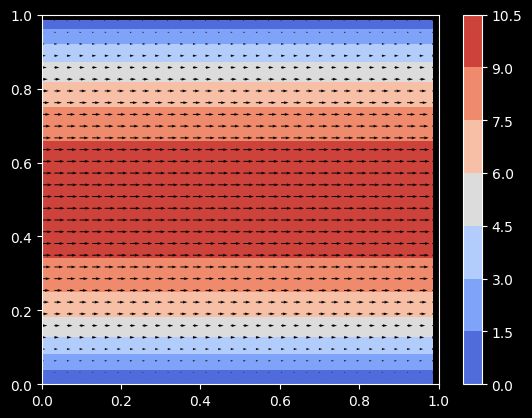

7.786089291399492


In [6]:
u_big, v_big, p_big = main()

100%|██████████| 5000/5000 [00:10<00:00, 457.21it/s]


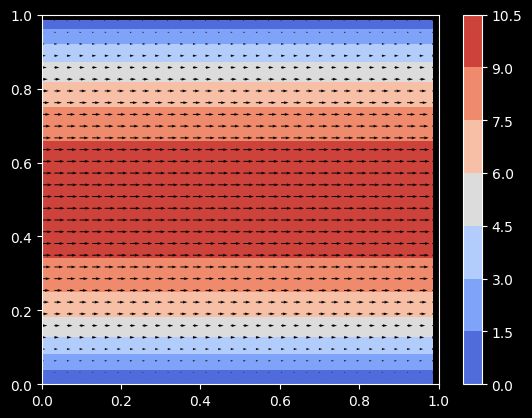

7.786089291399492


In [7]:
N_POINTS = 64
u_min, v_min, p_min = main()